# GAN Development - Kochems Approach


## Import libraries

In [29]:
%load_ext autoreload
%autoreload 2

from sklearn.preprocessing import MinMaxScaler
import io
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import csv
from collections import defaultdict
from data_reader import DataReader
from torch.autograd import Variable, grad
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
import seaborn as sns
from datetime import datetime
import plotly.figure_factory as ff
import kaleido
import wandb
from PIL import Image
import os
import random

wandb_dir = os.path.expanduser("~")

np.set_printoptions(threshold=np.inf)
torch.manual_seed(42)
np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


## Read in Data

### Functions to preprocess data

In [31]:
def convert_ask_bid_int(dataset):
    mask_ask = np.char.endswith(dataset[:,:,2], 'ask')
    mask_bid = np.char.endswith(dataset[:,:,2], 'bid')
    dataset[:,:,2][mask_ask] = '1'
    dataset[:,:,2][mask_bid] = '0'
    dataset = dataset.astype(np.float32)
    return dataset
    
    
def get_dataset_max_price(dataset, rows_per_orderbook, level = -1):
    index_on_each_OB = 0
    if level != -1:
        index_on_each_OB = (rows_per_orderbook//2-(level))
    last_row_prices = dataset[:, index_on_each_OB, 0]
    max_val = np.max(last_row_prices)
    return max_val

def get_dataset_min_price(dataset, rows_per_orderbook, level = -1):
    index_on_each_OB = -1
    if level != -1:
        index_on_each_OB = (rows_per_orderbook//2+(level-1))
    first_row_prices = dataset[:, index_on_each_OB, 0]
    min_val = np.min(first_row_prices)
    return min_val

def make_histogram_from_dataset(dataset, rows_per_orderbook = 100, bin_width = 0.5, level = -1):
    X_train = []
    hist_max = get_dataset_max_price(dataset, rows_per_orderbook, level)
    hist_min = get_dataset_min_price(dataset, rows_per_orderbook, level)
    print("range: ", hist_min, " ", hist_max)
    num_bins = int(np.ceil((hist_max-hist_min) / bin_width))
    bins = np.linspace(hist_min, hist_max, num_bins)
    for i in range(len(dataset)):
        orderbook = dataset[i]
        price = orderbook[:,0]
        quantity = orderbook[:,1]
        quantity[orderbook[:, 2] == 0] *= -1
        hist, bin_edges = np.histogram(price, bins=bins, weights=quantity)
        X_train.append(hist)
    X_train = np.array(X_train)
    return X_train, hist_min, hist_max, bins

def make_centred_LOB_snapshots(histograms, level = 1):
    X_train = []
    y_train = []
    for i in range(len(histograms)-1):
        current_OB = histograms[i]
        next_OB = histograms[i+1]
        j = -1
        while j < len(current_OB)-1 and not (current_OB[j] < 0 and current_OB[j+1] > 0): j+=1
        j+=1
        
        current_start_index = j-level
        current_subarray_size = 2 * level
        current_centre_LOB_snapshot = current_OB[current_start_index: current_start_index + current_subarray_size]
        
        next_subarray_size = 2 * current_subarray_size
        next_centre_LOB_snapshot = next_OB[current_start_index - level: (current_start_index - level) + next_subarray_size]
        
        if np.any(next_centre_LOB_snapshot == 0):
            continue
        
        X_train.append(current_centre_LOB_snapshot)
        y_train.append(next_centre_LOB_snapshot)
    
    X_train = np.vstack(X_train)
    y_train = np.vstack(y_train)
    
    return X_train, y_train
        
def normalization(X_train, c=8):
    sqrt_abs_over_c = np.sqrt(np.abs(X_train)) / c
    with_sign = np.sign(X_train) * sqrt_abs_over_c
    return with_sign

def get_centre_of_LOB(X_t_delta_t, level=3):
    index = -1
    for i in range(len(X_t_delta_t)-1):
        if X_t_delta_t[i] < 0 and X_t_delta_t[i+1]>0: index = i+1
    return X_t_delta_t[(index-level): (index-level) + 2 * level]

def get_centre_of_LOB_dataset(X_t_delta_t_dataset, level = 3):
    centres = []
    for i in range(len(X_t_delta_t_dataset)):
        if np.any(X_t_delta_t_dataset[i] == 0): continue
        centre = get_centre_of_LOB(X_t_delta_t_dataset[i], level)
        if centre.size != 6: continue
        centres.append(centre)
    np.array(centres)
    return centres
            

### Functions to post-process data

In [32]:
def reverse_normalization(X_train_normalized, c=8):
    if not isinstance(X_train_normalized, np.ndarray) and X_train_normalized.device.type == 'cuda':
        X_train_normalized = X_train_normalized.cpu()
    unscaled_data = X_train_normalized * c
    X_train = np.sign(X_train_normalized) * (unscaled_data ** 2)
    return X_train
    

### Functions to graph

In [33]:
def draw_avg_centre_comparison(X_t_delta_t_generated_dataset, real_dataset, level = 3):
    generated_dataset_centres = get_centre_of_LOB_dataset(X_t_delta_t_generated_dataset, level)
    mean_real = np.mean(real_dataset, axis=0)
    mean_fake = np.mean(generated_dataset_centres, axis=0)
    interleaved_array = np.empty(mean_real.size + mean_fake.size, dtype=mean_real.dtype)
    interleaved_array[0::2] = mean_real
    interleaved_array[1::2] = mean_fake
    indices = np.arange(len(interleaved_array))
    return indices, interleaved_array

### Actually reading in data

In [34]:
data_reader = DataReader("./orderbook_snapshots.csv", rows_per_orderbook=100)
data_reader.read_csv()
X_train_raw = data_reader.get_data()
X_train_raw = convert_ask_bid_int(X_train_raw)
print(X_train_raw.shape)

(78252, 100, 3)


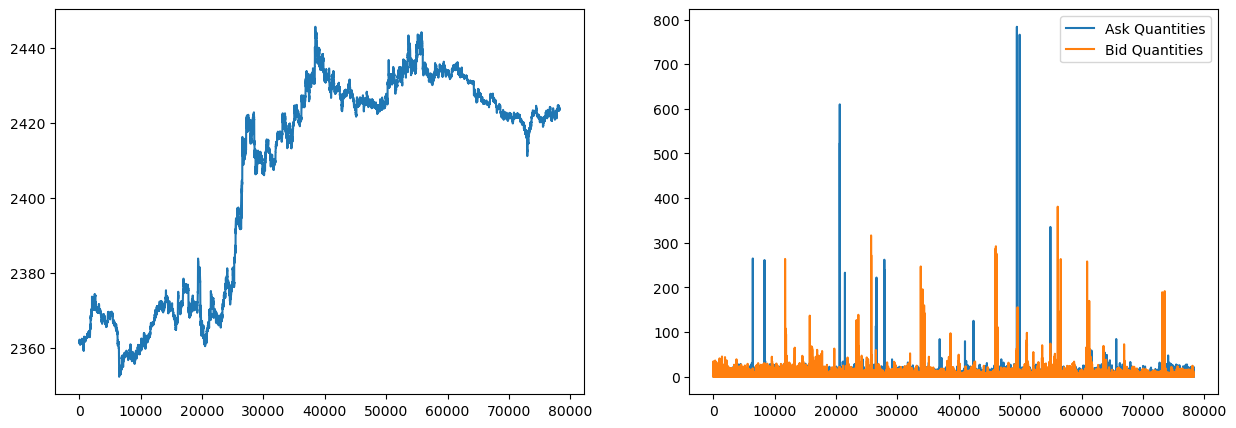

In [35]:
best_prices = (X_train_raw[:, 49, 0] + X_train_raw[:, 50, 0]) /2
best_ask_quantities = X_train_raw[:, 49, 1]
best_bid_quantities = np.abs(X_train_raw[:, 50, 1])

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(best_prices, label='Prices')
axes[1].plot(best_ask_quantities, label='Ask Quantities')
axes[1].plot(best_bid_quantities, label='Bid Quantities')
plt.legend()
plt.show()

### Preprocess data

In [36]:
histograms, price_min, price_max, bins = make_histogram_from_dataset(X_train_raw, rows_per_orderbook=100, bin_width=0.5, level=-1)
print(histograms.shape)
print(bins)

range:  2346.7   2452.7
(78252, 211)
[2346.69995117 2347.20232084 2347.70469051 2348.20706018 2348.70942984
 2349.21179951 2349.71416918 2350.21653885 2350.71890852 2351.22127819
 2351.72364785 2352.22601752 2352.72838719 2353.23075686 2353.73312653
 2354.2354962  2354.73786586 2355.24023553 2355.7426052  2356.24497487
 2356.74734454 2357.24971421 2357.75208387 2358.25445354 2358.75682321
 2359.25919288 2359.76156255 2360.26393221 2360.76630188 2361.26867155
 2361.77104122 2362.27341089 2362.77578056 2363.27815022 2363.78051989
 2364.28288956 2364.78525923 2365.2876289  2365.78999857 2366.29236823
 2366.7947379  2367.29710757 2367.79947724 2368.30184691 2368.80421657
 2369.30658624 2369.80895591 2370.31132558 2370.81369525 2371.31606492
 2371.81843458 2372.32080425 2372.82317392 2373.32554359 2373.82791326
 2374.33028293 2374.83265259 2375.33502226 2375.83739193 2376.3397616
 2376.84213127 2377.34450093 2377.8468706  2378.34924027 2378.85160994
 2379.35397961 2379.85634928 2380.3587189

### Non-Marginal Histogram of all Orderbook States

(78138, 6)   (78138, 12)
[-38.811523 -50.756104 -27.78772   25.371094  94.59961  256.45312 ]
[-208.55713   -87.99841  -166.2403    -44.319336  -47.312866  -24.945312
   23.384766   86.31836   256.45312    70.82385   156.65088    72.88672 ]


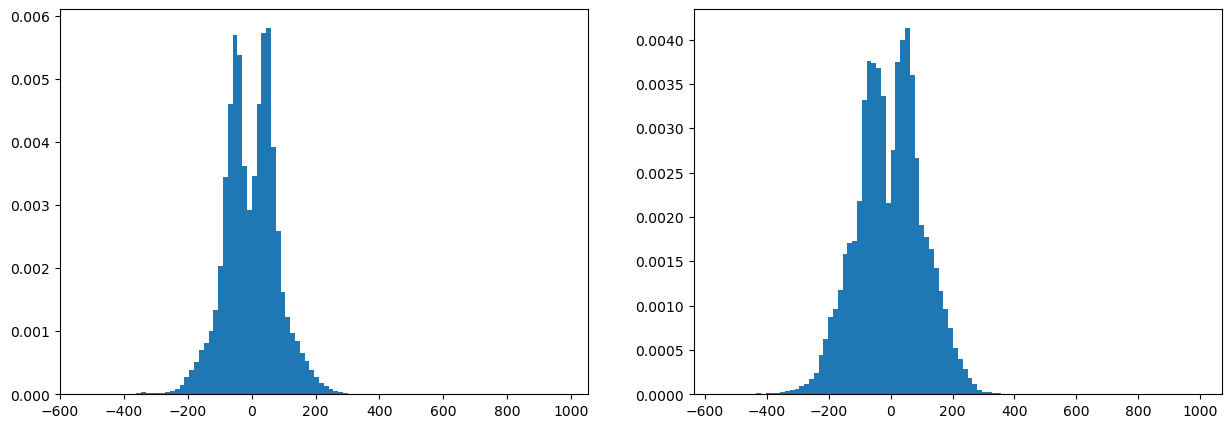

(78138, 6)   (78138, 12)
[-1.0383149  -1.1873887  -0.87856764  0.8394954   1.6210389   2.6690257 ]
[-2.4069178  -1.5634578  -2.1489034  -1.1095462  -1.1464058  -0.83242136
  0.8059633   1.5484613   2.6690257   1.4026151   2.086004    1.4228953 ]


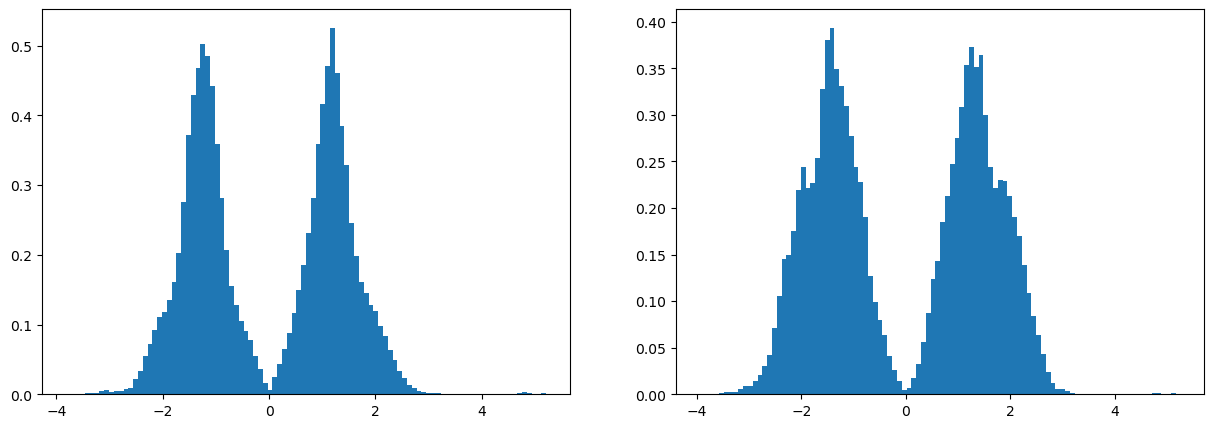

In [37]:
X_train_not_processed, y_train_not_processed = make_centred_LOB_snapshots(histograms, level=3)
print(X_train_not_processed.shape," ",y_train_not_processed.shape)
print(X_train_not_processed[0])
print(y_train_not_processed[0])
all_orders = X_train_not_processed.ravel()
all_orders_next = y_train_not_processed.ravel()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(all_orders, bins=100, density=True)
axes[1].hist(all_orders_next, bins=100, density=True)

plt.show()

S_t_dataset = normalization(X_train=X_train_not_processed,c=6)
X_t_delta_t_dataset = normalization(X_train=y_train_not_processed,c=6)
print(S_t_dataset.shape," ", X_t_delta_t_dataset.shape)
print(S_t_dataset[0])
print(X_t_delta_t_dataset[0])

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(S_t_dataset.ravel(), bins=100, density=True)
axes[1].hist(X_t_delta_t_dataset.ravel(), bins=100, density=True)

plt.show()

### Marginal Distributions (Normalized)

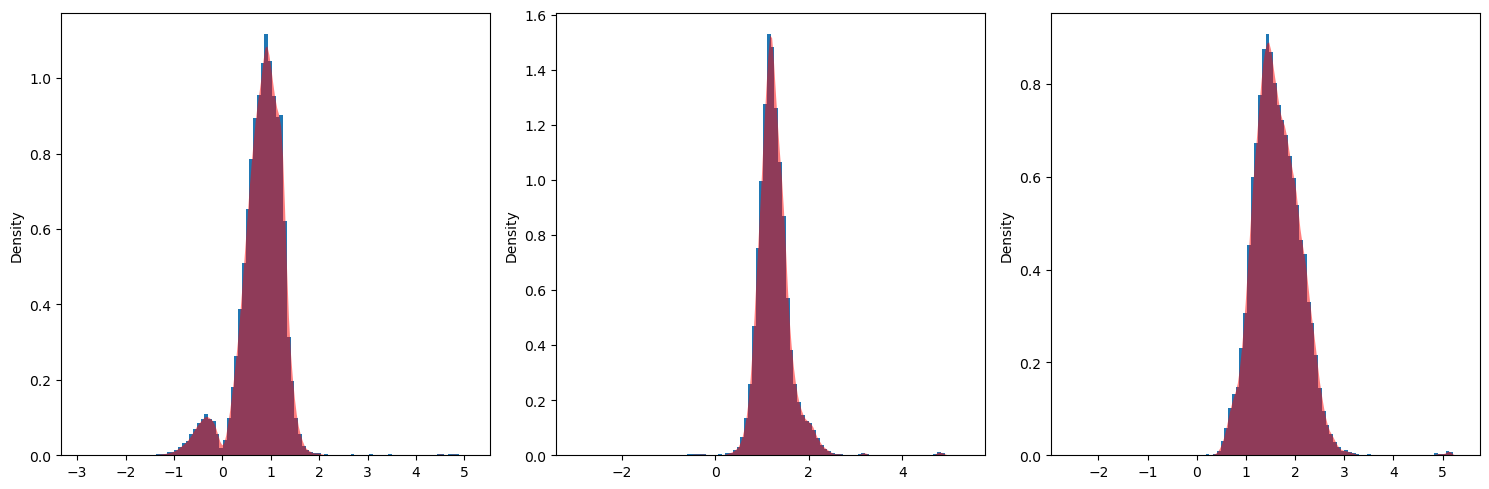

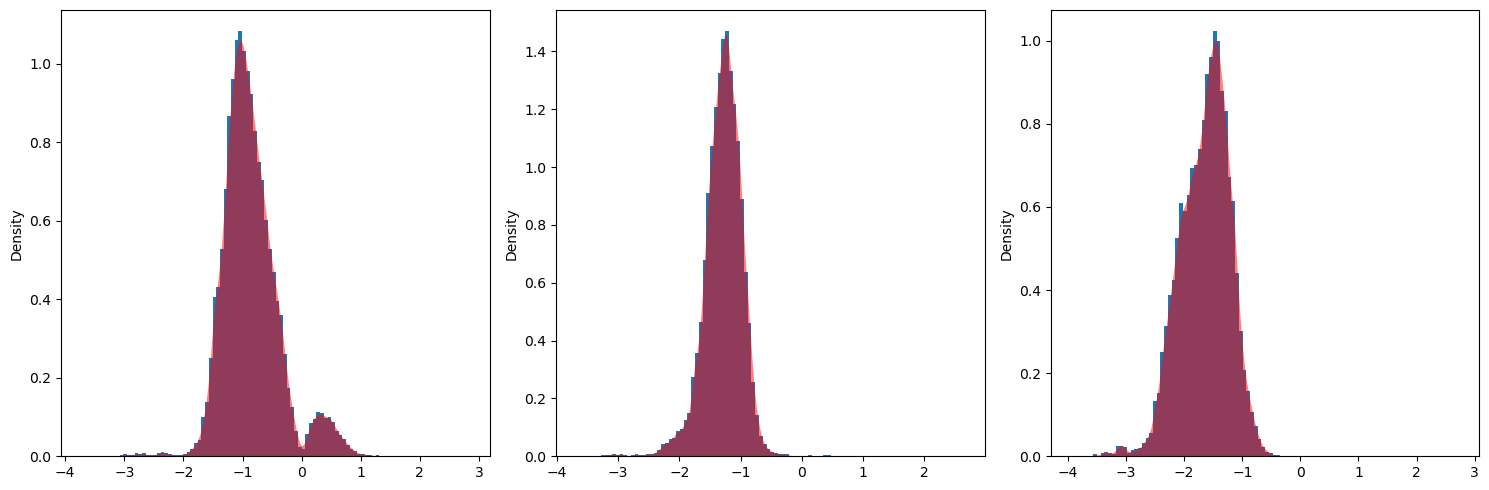

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Replace inf and -inf with NaN in your dataset columns
X_t_delta_t_dataset = np.where(np.isinf(X_t_delta_t_dataset), np.nan, X_t_delta_t_dataset)

# Assuming you've defined X_t_delta_t_dataset
asks_1 = X_t_delta_t_dataset[:, 6].astype(float)
asks_2 = X_t_delta_t_dataset[:, 7].astype(float)
asks_3 = X_t_delta_t_dataset[:, 8].astype(float)

# Remove or handle NaN values if necessary
# For example, drop NaN values for plotting
asks_1 = asks_1[~np.isnan(asks_1)]
asks_2 = asks_2[~np.isnan(asks_2)]
asks_3 = asks_3[~np.isnan(asks_3)]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(asks_1, bins=100, density=True)
sns.kdeplot(asks_1, ax=axes[0], color='red', fill=True, linewidth=0, alpha=0.5)
axes[1].hist(asks_2, bins=100, density=True)
sns.kdeplot(asks_2, ax=axes[1], color='red', fill=True, linewidth=0, alpha=0.5)
axes[2].hist(asks_3, bins=100, density=True)
sns.kdeplot(asks_3, ax=axes[2], color='red', fill=True, linewidth=0, alpha=0.5)

plt.tight_layout()
plt.show()

# Repeat the process for bids
bids_1 = X_t_delta_t_dataset[:, 5].astype(float)
bids_2 = X_t_delta_t_dataset[:, 4].astype(float)
bids_3 = X_t_delta_t_dataset[:, 3].astype(float)

# Remove or handle NaN values if necessary
bids_1 = bids_1[~np.isnan(bids_1)]
bids_2 = bids_2[~np.isnan(bids_2)]
bids_3 = bids_3[~np.isnan(bids_3)]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(bids_1, bins=100, density=True)
sns.kdeplot(bids_1, ax=axes[0], color='red', fill=True, linewidth=0, alpha=0.5)
axes[1].hist(bids_2, bins=100, density=True)
sns.kdeplot(bids_2, ax=axes[1], color='red', fill=True, linewidth=0, alpha=0.5)
axes[2].hist(bids_3, bins=100, density=True)
sns.kdeplot(bids_3, ax=axes[2], color='red', fill=True, linewidth=0, alpha=0.5)

plt.tight_layout()
plt.show()



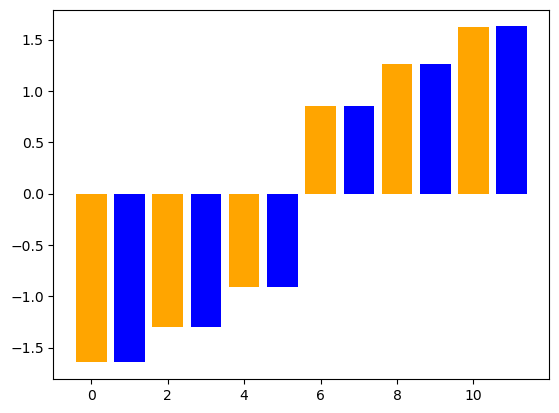

In [39]:
indices, interleaved_array = draw_avg_centre_comparison(X_t_delta_t_dataset, S_t_dataset, level = 3)
plt.bar(indices, interleaved_array, color=['orange', 'blue'] * (len(interleaved_array) // 2))
plt.show()

In [40]:
S_t_dataset_tensor = torch.tensor(S_t_dataset, dtype=torch.float32).to(device)
X_t_delta_t_dataset_tensor = torch.tensor(X_t_delta_t_dataset, dtype=torch.float32).to(device)
dataset = TensorDataset(X_t_delta_t_dataset_tensor, S_t_dataset_tensor)
data_loader = DataLoader(dataset, batch_size=1000, shuffle=True)

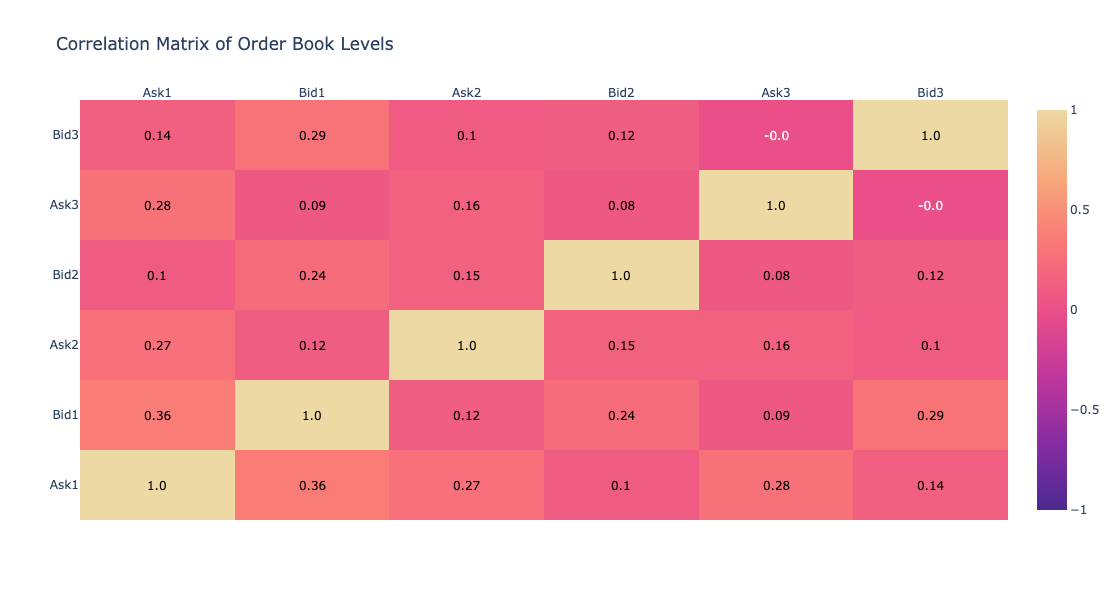

In [41]:
# import numpy as np
# import pandas as pd

# # First, select the relevant slices of the array for bid_1, bid_2, bid_3, ask_1, ask_2, and ask_3
# data = X_t_delta_t_dataset[:, [6, 5, 7, 4, 8, 3]]

# # Convert this data into a pandas DataFrame
# columns = ['Ask1', 'Bid1', 'Ask2', 'Bid2', 'Ask3', 'Bid3']
# df = pd.DataFrame(data, columns=columns)
# df.dropna(inplace=True)     # Example: Drop rows with NaNs

# # Compute the correlation matrix
# correlation_matrix = df.corr()

# # Plotting the correlation matrix as a heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar=True, vmin=-1, vmax=1)
# plt.title('Correlation Matrix of Order Book Levels')
# plt.show()


# Assuming X_t_delta_t_dataset is correctly defined earlier in your script
data = X_t_delta_t_dataset[:, [6, 5, 7, 4, 8, 3]]

# Convert this data into a pandas DataFrame
columns = ['Ask1', 'Bid1', 'Ask2', 'Bid2', 'Ask3', 'Bid3']
df = pd.DataFrame(data, columns=columns)

# Ensure data types are numeric for correlation computation
df = df.apply(pd.to_numeric, errors='coerce')

# Compute the correlation matrix
correlation_matrix = df.corr()

# Generate the heatmap
fig = ff.create_annotated_heatmap(
    z=correlation_matrix.to_numpy(),
    x=correlation_matrix.columns.tolist(),
    y=correlation_matrix.columns.tolist(),
    annotation_text=correlation_matrix.round(2).to_numpy(),
    colorscale='agsunset',
    showscale=True,
    zmin=-1, # Set minimum of scale
    zmax=1  # Set maximum of scale
)

# Update layout to make it more readable
fig.update_layout(
    title='Correlation Matrix of Order Book Levels',
    xaxis=dict(tickmode='array', tickvals=np.arange(len(columns)), ticktext=columns),
    yaxis=dict(tickmode='array', tickvals=np.arange(len(columns)), ticktext=columns),
    width=600, 
    height=600,
)

fig.show()

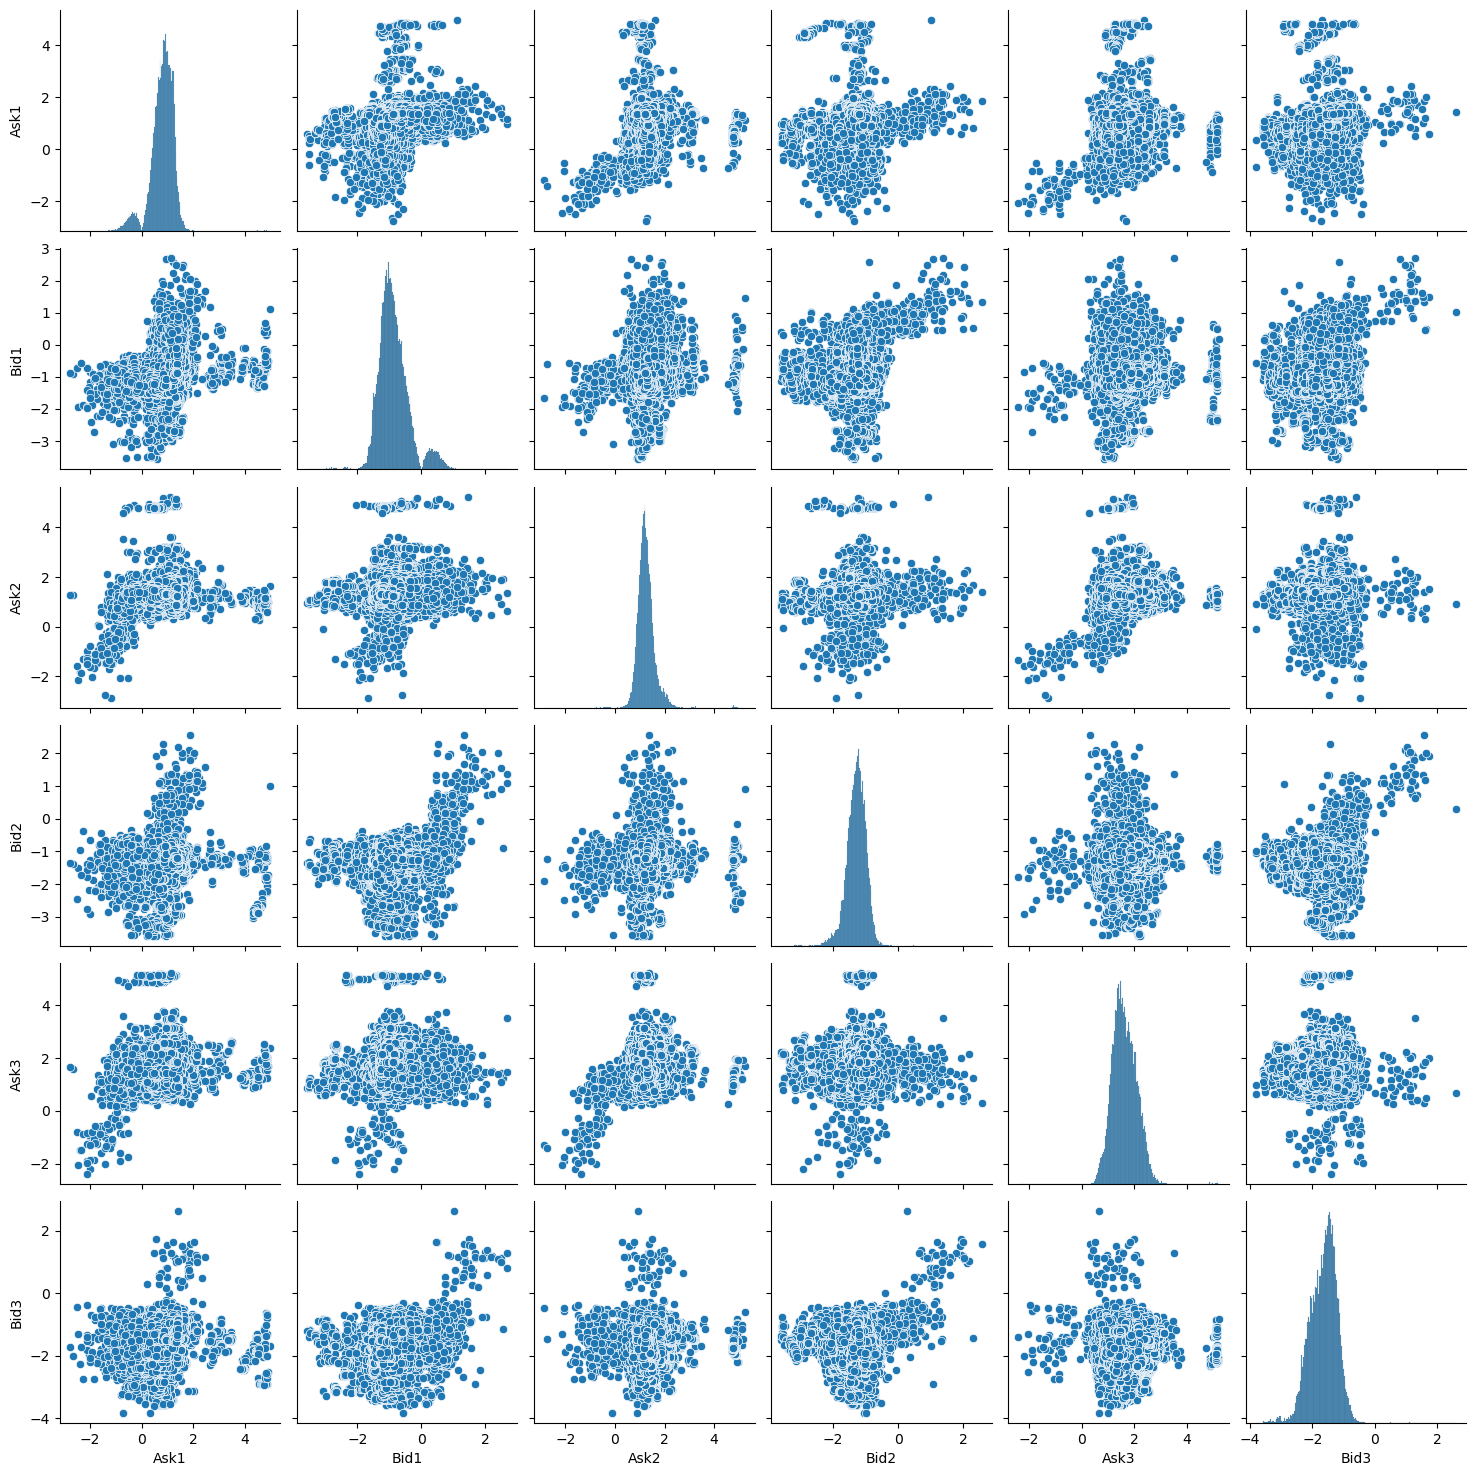

In [42]:
# First, select the relevant slices of the array for bid_1, bid_2, bid_3, ask_1, ask_2, and ask_3
data = X_t_delta_t_dataset[:, [6, 5, 7, 4, 8, 3]]

# Convert this data into a pandas DataFrame
columns = ['Ask1', 'Bid1', 'Ask2', 'Bid2', 'Ask3', 'Bid3']
df = pd.DataFrame(data, columns=columns)

sns.pairplot(df)

## WGAN-GP Training

### Defining the Critic and Generator

In [44]:

class Generator(nn.Module):
    def __init__(self, latent_dim=6, n=6):
        super(Generator, self).__init__()
        self.h_11 = nn.Linear(latent_dim,64).to(device)
        self.h_12 = nn.Linear(n,64).to(device)
        self.h_21 = nn.Linear(64,64).to(device)
        self.h_22 = nn.Linear(64,64).to(device)
        self.h_32 = nn.Linear(128, 128).to(device)
        #output layer
        self.output = nn.Linear(128, 12).to(device)
        # self.h_35 = nn.Linear(6, 6).to(device)

    def forward(self, Z_t, S_t):
        Z_t = Z_t.to(device)  # Move input tensor to the device
        S_t = S_t.to(device)  # Move input tensor to the device

        h_11_output = torch.relu(self.h_11(Z_t))
        h_21_output = torch.relu(self.h_21(h_11_output))
        
        h_12_output = torch.relu(self.h_12(S_t))
        h_22_output = torch.relu(self.h_22(h_12_output))
        
        # Concatenation
        h_31_output = torch.cat((h_21_output, h_22_output), dim=1)
        
        h_32_output = torch.relu(self.h_32(h_31_output))
        output = self.output(h_32_output)
        
        return output

class Critic(nn.Module):
    def __init__(self, n_1=12, n_2=6):
        super(Critic, self).__init__()
        self.h_11 = nn.Linear(n_1,64).to(device)
        self.h_12 = nn.Linear(n_2,64).to(device)
        self.h_21 = nn.Linear(64,64).to(device)
        self.h_22 = nn.Linear(64,64).to(device)
        
        self.h_32 = nn.Linear(128,32).to(device)
        #output layer
        self.output = nn.Linear(32, 1).to(device)

    def forward(self, X_t_delta_t, S_t):
        X_t_delta_t = X_t_delta_t.to(device)  # Move input tensor to the device
        S_t = S_t.to(device)  # Move input tensor to the device

        h_11_output = torch.relu(self.h_11(X_t_delta_t))
        h_21_output = torch.relu(self.h_21(h_11_output))
        
        h_12_output = torch.relu(self.h_12(S_t))
        h_22_output = torch.relu(self.h_22(h_12_output))

        # Concatenation
        h_31_output = torch.cat((h_21_output, h_22_output), dim=1)

        h_32_output = torch.relu(self.h_32(h_31_output))
        output = self.output(h_32_output)
        
        return output


In [45]:
# Define training hyperparameters
n_critic = 5
z_t_dim = 12
LAMBDA = 10
epochs = 100000
learning_rate = 0.00001
start_epoch = 0

# Instantiate the generator and discriminator with device adaptation
generator = Generator(latent_dim=z_t_dim, n=6).to(device)
critic = Critic(n_1=12, n_2=6).to(device)

# Define the optimisers
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0, 0.9))
optimizer_D = optim.RMSprop(critic.parameters(), lr=learning_rate, eps=1e-8, alpha=0.99)

avg_d_loss_list = []
avg_g_loss_list = []

### Defining the training loop

#### Wandb run location

In [46]:
runname = "RecreatingBestModelBimodal"

### USE BELOW TO LOAD EXISTING RUN ONLY

In [19]:
wandb.init(
    project="uolse",
    id="1isofpa1",
    resume="must",
    dir=wandb_dir
)

wandb: Currently logged in as: honnallishreyas (uolse). Use `wandb login --relogin` to force relogin


### USE BELOW TO CREATE EXISTING EXISTING RUN ONLY

In [47]:
wandb.init(
    # set the wandb project where this run will be logged
    project="uolse",
    name=runname,
    # track hyperparameters and run metadata
    config={
    "learning_rate": learning_rate,
    "architecture generator": Generator,
    "architecture critic": Critic,
    "dataset": "OurDataset",
    "epochs": epochs,
    "z_t_dim": z_t_dim,
    "LAMBDA": LAMBDA,
    "runname": runname,
    },
    dir=wandb_dir
)

Loss/Discriminator,▁█▆▅▅▅▅▅▆▅▅▆▆▆▆▅▅▅▅▄▅▅▅▅▅▅▄▄▅▅▅▅▅▄▅▅▅▅▅▅
Loss/Generator,█▂▁▂▃▃▂▃▄▅▆▆▆▇▇▆▇▇▆▆▆▅▅▃▄▃▃▃▃▃▄▄▄▄▄▃▄▄▄▁
Loss/Discriminator,-0.08307
Loss/Generator,-5.59862


#### Wandb functions

In [48]:
def write_marginal_distributions_to_wandb(epoch, X_t_delta_t_generated):
    # Function to create and log a KDE plot
    def log_kde_plot(data, title, epoch):
        plt.figure(figsize=(10, 6))
        plt.hist(data.cpu().numpy(), bins=100, density=True)
        sns.kdeplot(data.cpu().numpy(), color='red', fill=True, alpha=0.5)
        plt.title(title)
        # Save the plot to a buffer
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        image = np.array(plt.imread(buf))
        plt.close()
        # Log the plot to Weights & Biases
        wandb.log({f'KDE Plot {title}': wandb.Image(image, caption=title)}, step=epoch)
    
    # Indices for asks and bids might need adjustment based on dataset structure
    asks_bids_indices = {
        'Ask 1': 6,
        'Ask 2': 7,
        'Ask 3': 8,
        'Bid 1': 5,
        'Bid 2': 4,
        'Bid 3': 3,
    }

    for title, index in asks_bids_indices.items():
        data = X_t_delta_t_generated[:, index]
        log_kde_plot(data, title, epoch)
        
def write_covariance_matrix_of_generated_data_to_wandb(epoch, X_t_delta_t_generated):
    data = X_t_delta_t_generated[:, [6, 5, 7, 4, 8, 3]].cpu().numpy()
    columns = ['Ask1', 'Bid1', 'Ask2', 'Bid2', 'Ask3', 'Bid3']
    df = pd.DataFrame(data, columns=columns)
    df = df.apply(pd.to_numeric, errors='coerce')
    correlation_matrix = df.corr()

    fig = ff.create_annotated_heatmap(
        z=correlation_matrix.to_numpy(),
        x=correlation_matrix.columns.tolist(),
        y=correlation_matrix.columns.tolist(),
        annotation_text=correlation_matrix.round(2).to_numpy(),
        colorscale='agsunset',
        showscale=True,
        zmin=-1, 
        zmax=1
    )

    fig.update_layout(
        title='Correlation Matrix of Order Book Levels',
        xaxis=dict(tickmode='array', tickvals=np.arange(len(columns)), ticktext=columns),
        yaxis=dict(tickmode='array', tickvals=np.arange(len(columns)), ticktext=columns),
        width=600, 
        height=600,
    )

    # Convert Plotly fig to PNG image using kaleido
    img_bytes = fig.to_image(format="png")
    image = Image.open(io.BytesIO(img_bytes))
    # Convert the PIL image to a NumPy array
    image_array = np.array(image)
    wandb.log({'Correlation Matrix of Order Book Levels': wandb.Image(image_array, caption='Correlation Matrix of Order Book Levels')}, step=epoch)
    
def write_pair_scatter_plot_to_wandb(epoch, X_t_delta_t_generated):
    best_k_ask_bids = X_t_delta_t_generated[:, [6, 5, 7, 4, 8, 3]].cpu().numpy()
    columns = ['Ask1', 'Bid1', 'Ask2', 'Bid2', 'Ask3', 'Bid3']
    df = pd.DataFrame(best_k_ask_bids, columns=columns)
    plt.figure()
    sns.pairplot(df)
    plt.title('Scatter plot of Orderbook Levels')
    # Convert plot to image bytes
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    image = plt.imread(buf)
    plt.close()
    # Log the image to Weights & Biases
    wandb.log({'Scatter plot of Orderbook Levels': wandb.Image(image, caption='Scatter plot of Orderbook Levels')}, step=epoch)

def write_overlay_pair_scatter_plot_to_wandb(epoch, X_t_delta_t_generated, X_t_delta_t_dataset):
    generated_data = X_t_delta_t_generated[:, [6, 5, 7, 4, 8, 3]].cpu().numpy()
    training_data = X_t_delta_t_dataset[:, [6, 5, 7, 4, 8, 3]]

    columns = ['Ask1', 'Bid1', 'Ask2', 'Bid2', 'Ask3', 'Bid3']
    df_generated = pd.DataFrame(generated_data, columns=columns)
    df_training = pd.DataFrame(training_data, columns=columns)

    # Overlay DataFrames with key
    df_combined = pd.concat([df_generated.assign(dataset='Generated'), df_training.assign(dataset='Training')])

    plt.figure()
    sns.pairplot(df_combined, hue='dataset', palette='bright', diag_kind='kde', plot_kws={'alpha':0.6})
    plt.suptitle('Overlay Scatter plot of Orderbook Levels', y=1.02)  # Adjust title placement

    # Convert plot to image bytes
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight') 
    buf.seek(0)
    image = plt.imread(buf)
    plt.close()

    # Log the image to Weights & Biases
    wandb.log({'Overlay Scatter plot of Orderbook Levels': wandb.Image(image, caption='Overlay Scatter plot of Orderbook Levels')}, step=epoch)
    
def write_metrics_to_wandb(epoch):
    with torch.no_grad():
        z_t = torch.randn(S_t_dataset.shape[0], z_t_dim)
        X_t_delta_t_generated = generator(z_t, S_t_dataset_tensor)
    write_marginal_distributions_to_wandb(epoch, X_t_delta_t_generated)
    write_covariance_matrix_of_generated_data_to_wandb(epoch, X_t_delta_t_generated)
    # write_pair_scatter_plot_to_wandb(epoch, X_t_delta_t_generated)
    write_overlay_pair_scatter_plot_to_wandb(epoch, X_t_delta_t_generated, X_t_delta_t_dataset)

        
def write_loss_functions_to_wandb(avg_d_loss, avg_g_loss,epoch):
    wandb.log({'Loss/Discriminator': avg_d_loss, 'Loss/Generator': avg_g_loss}, step=epoch)

### Functions to save and load Models

In [49]:
def save_checkpoint(epoch, generator, discriminator, optimizer_G, optimizer_D, avg_d_loss, avg_g_loss, filepath):
    torch.save({
        'epoch': epoch,
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_state_dict': optimizer_D.state_dict(),
        'avg_d_loss': avg_d_loss,
        'avg_g_loss': avg_g_loss
    }, filepath)


def load_checkpoint(filepath, generator, discriminator, optimizer_G, optimizer_D):
    checkpoint = torch.load(filepath)
    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
    optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
    epoch = checkpoint['epoch']
    avg_d_loss = checkpoint['avg_d_loss']
    avg_g_loss = checkpoint['avg_g_loss']
    return epoch, avg_d_loss, avg_g_loss



### ONLY RUN IF YOU WANT TO LOAD A MODEL AND CONTINUE IT FOR A RUN. MAKE SURE U LOAD WANDB RUN AND NOT CREATE A NEW WANDB RUN

In [ ]:
start_epoch, avg_d_loss, avg_g_loss = load_checkpoint('./saved_models/python/RecreatingBestModelBimodal.pth', generator, critic, optimizer_G, optimizer_D)
print(f"Resuming training from epoch {start_epoch}")

#### Gradient Penalty

In [24]:
def gradient_penalty(C, real_samples, fake_samples, batch_S_t):
    batch_size = real_samples.size(0)
    # Ensure alpha is shaped correctly for broadcasting
    alpha = torch.rand(batch_size, 1, device=device)
    alpha = alpha.expand(batch_size, real_samples.nelement() // batch_size).contiguous().view(batch_size, -1)

    # Calculate interpolates
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = C(interpolates, batch_S_t)
    
    fake = Variable(torch.Tensor(batch_size , 1).fill_(1.0), requires_grad=False).to(device)
    gradients = grad(outputs=d_interpolates, inputs=interpolates, grad_outputs=fake,
                     create_graph=True, retain_graph=True, only_inputs=True)[0]

    # Flatten the gradients
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [51]:

def generate_z_t(batch_size = 64, z_t_dim = 12, device=None):
    # Sample from bimodal distribution for the first 3 dimensions
    mean1, std_dev1 = -2, 1
    mean2, std_dev2 = 2, 1

    # Choose distributions for each element
    bimodal_indices = torch.rand(batch_size, z_t_dim, device=device) < 0.5

    # Generate samples for the first 3 dimensions
    samples = torch.empty(batch_size, z_t_dim, device=device)
    samples[:, :3] = torch.where(bimodal_indices[:, :3], 
                                 torch.randn(batch_size, 3, device=device) * std_dev1 + mean1, 
                                 torch.randn(batch_size, 3, device=device) * std_dev2 + mean2)

    # Generate samples for the remaining dimensions from a normal distribution
    mean, std_dev = 0, 1
    samples[:, 3:] = torch.randn(batch_size, z_t_dim - 3, device=device) * std_dev + mean

    return samples
'''

def generate_z_t(batch_size=64, z_t_dim=12, device=None):
    # Sample from bimodal distribution for all dimensions
    mean1, std_dev1 = -2, 1
    mean2, std_dev2 = 2, 1

    # Choose distributions for each element
    bimodal_indices = torch.rand(batch_size, z_t_dim, device=device) < 0.5

    # Generate samples from bimodal distribution
    samples = torch.empty(batch_size, z_t_dim, device=device)
    samples = torch.where(bimodal_indices, 
                          torch.randn(batch_size, z_t_dim, device=device) * std_dev1 + mean1, 
                          torch.randn(batch_size, z_t_dim, device=device) * std_dev2 + mean2)

    return samples
'''

'\n\ndef generate_z_t(batch_size=64, z_t_dim=12, device=None):\n    # Sample from bimodal distribution for all dimensions\n    mean1, std_dev1 = -2, 1\n    mean2, std_dev2 = 2, 1\n\n    # Choose distributions for each element\n    bimodal_indices = torch.rand(batch_size, z_t_dim, device=device) < 0.5\n\n    # Generate samples from bimodal distribution\n    samples = torch.empty(batch_size, z_t_dim, device=device)\n    samples = torch.where(bimodal_indices, \n                          torch.randn(batch_size, z_t_dim, device=device) * std_dev1 + mean1, \n                          torch.randn(batch_size, z_t_dim, device=device) * std_dev2 + mean2)\n\n    return samples\n'

#### Training Loop of WGAN with Gradient Penalty

wandb: WARNING Step only supports monotonically increasing values, use define_metric to set a custom x axis. For details see: https://wandb.me/define-metric
wandb: WARNING (User provided step: 0 is less than current step: 14. Dropping entry: {'Loss/Discriminator': -3.71598017970218, 'Loss/Generator': 0.18863480321214168, '_timestamp': 1712068947.6679525}).
wandb: WARNING (User provided step: 1 is less than current step: 14. Dropping entry: {'Loss/Discriminator': -3.473590038999726, 'Loss/Generator': 0.1720519726034961, '_timestamp': 1712068949.0043383}).
wandb: WARNING (User provided step: 2 is less than current step: 14. Dropping entry: {'Loss/Discriminator': -3.202372770068013, 'Loss/Generator': 0.09825804235437248, '_timestamp': 1712068950.3554947}).
wandb: WARNING (User provided step: 3 is less than current step: 14. Dropping entry: {'Loss/Discriminator': -2.9224683399441886, 'Loss/Generator': 0.07567906785237638, '_timestamp': 1712068951.8311498}).
wandb: WARNING (User provided st

Epoch [20/100000] completed. Avg D Loss: -1.0568, Avg G Loss: 0.9834


wandb: WARNING (User provided step: 12 is less than current step: 14. Dropping entry: {'Loss/Discriminator': -1.0614952343928663, 'Loss/Generator': 1.385252235810968, '_timestamp': 1712068964.3826165}).
wandb: WARNING (User provided step: 13 is less than current step: 14. Dropping entry: {'Loss/Discriminator': -1.0904812100567396, 'Loss/Generator': 1.3998095385635956, '_timestamp': 1712068965.8710458}).


Epoch [40/100000] completed. Avg D Loss: -0.7412, Avg G Loss: 1.0409
Epoch [60/100000] completed. Avg D Loss: -0.4548, Avg G Loss: 1.3109
Epoch [80/100000] completed. Avg D Loss: -0.3373, Avg G Loss: 0.9163
Epoch [100/100000] completed. Avg D Loss: -0.1745, Avg G Loss: 0.5725
Epoch [120/100000] completed. Avg D Loss: -0.2713, Avg G Loss: -0.1716
Epoch [140/100000] completed. Avg D Loss: -0.2831, Avg G Loss: -0.5600
Epoch [160/100000] completed. Avg D Loss: -0.2880, Avg G Loss: 0.0492
Epoch [180/100000] completed. Avg D Loss: -0.2175, Avg G Loss: 0.1485
Epoch [200/100000] completed. Avg D Loss: -0.1763, Avg G Loss: 0.5764
Epoch [220/100000] completed. Avg D Loss: -0.0216, Avg G Loss: -2.0511
Epoch [240/100000] completed. Avg D Loss: -0.1236, Avg G Loss: -3.0087
Epoch [260/100000] completed. Avg D Loss: -0.0900, Avg G Loss: -2.6673
Epoch [280/100000] completed. Avg D Loss: -0.0576, Avg G Loss: -1.2170
Epoch [300/100000] completed. Avg D Loss: -0.0592, Avg G Loss: -1.1796
Epoch [320/10000

/uolstore/home/users/sc20sh/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:1280: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



Epoch [10020/100000] completed. Avg D Loss: -0.0551, Avg G Loss: -14.9541
Epoch [10040/100000] completed. Avg D Loss: -0.0567, Avg G Loss: -14.8824
Epoch [10060/100000] completed. Avg D Loss: -0.0559, Avg G Loss: -14.8134
Epoch [10080/100000] completed. Avg D Loss: -0.0551, Avg G Loss: -14.7734
Epoch [10100/100000] completed. Avg D Loss: -0.0551, Avg G Loss: -14.8522
Epoch [10120/100000] completed. Avg D Loss: -0.0545, Avg G Loss: -14.9389
Epoch [10140/100000] completed. Avg D Loss: -0.0528, Avg G Loss: -14.9804
Epoch [10160/100000] completed. Avg D Loss: -0.0533, Avg G Loss: -15.1311
Epoch [10180/100000] completed. Avg D Loss: -0.0523, Avg G Loss: -15.2351
Epoch [10200/100000] completed. Avg D Loss: -0.0526, Avg G Loss: -15.3011
Epoch [10220/100000] completed. Avg D Loss: -0.0520, Avg G Loss: -15.3396
Epoch [10240/100000] completed. Avg D Loss: -0.0531, Avg G Loss: -15.4964
Epoch [10260/100000] completed. Avg D Loss: -0.0519, Avg G Loss: -15.5418
Epoch [10280/100000] completed. Avg D 

/tmp/ipykernel_81208/1771113108.py:4: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.

/tmp/ipykernel_81208/1771113108.py:4: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.

/tmp/ipykernel_81208/1771113108.py:4: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_op

Epoch [10520/100000] completed. Avg D Loss: -0.0549, Avg G Loss: -15.8522
Epoch [10540/100000] completed. Avg D Loss: -0.0553, Avg G Loss: -15.7632
Epoch [10560/100000] completed. Avg D Loss: -0.0556, Avg G Loss: -15.8719
Epoch [10580/100000] completed. Avg D Loss: -0.0555, Avg G Loss: -15.8047
Epoch [10600/100000] completed. Avg D Loss: -0.0560, Avg G Loss: -15.9150
Epoch [10620/100000] completed. Avg D Loss: -0.0556, Avg G Loss: -15.9258
Epoch [10640/100000] completed. Avg D Loss: -0.0566, Avg G Loss: -16.0255
Epoch [10660/100000] completed. Avg D Loss: -0.0561, Avg G Loss: -16.1753
Epoch [10680/100000] completed. Avg D Loss: -0.0563, Avg G Loss: -16.2082
Epoch [10700/100000] completed. Avg D Loss: -0.0568, Avg G Loss: -16.2427
Epoch [10720/100000] completed. Avg D Loss: -0.0563, Avg G Loss: -16.3209
Epoch [10740/100000] completed. Avg D Loss: -0.0571, Avg G Loss: -16.4300
Epoch [10760/100000] completed. Avg D Loss: -0.0561, Avg G Loss: -16.5249
Epoch [10780/100000] completed. Avg D 

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

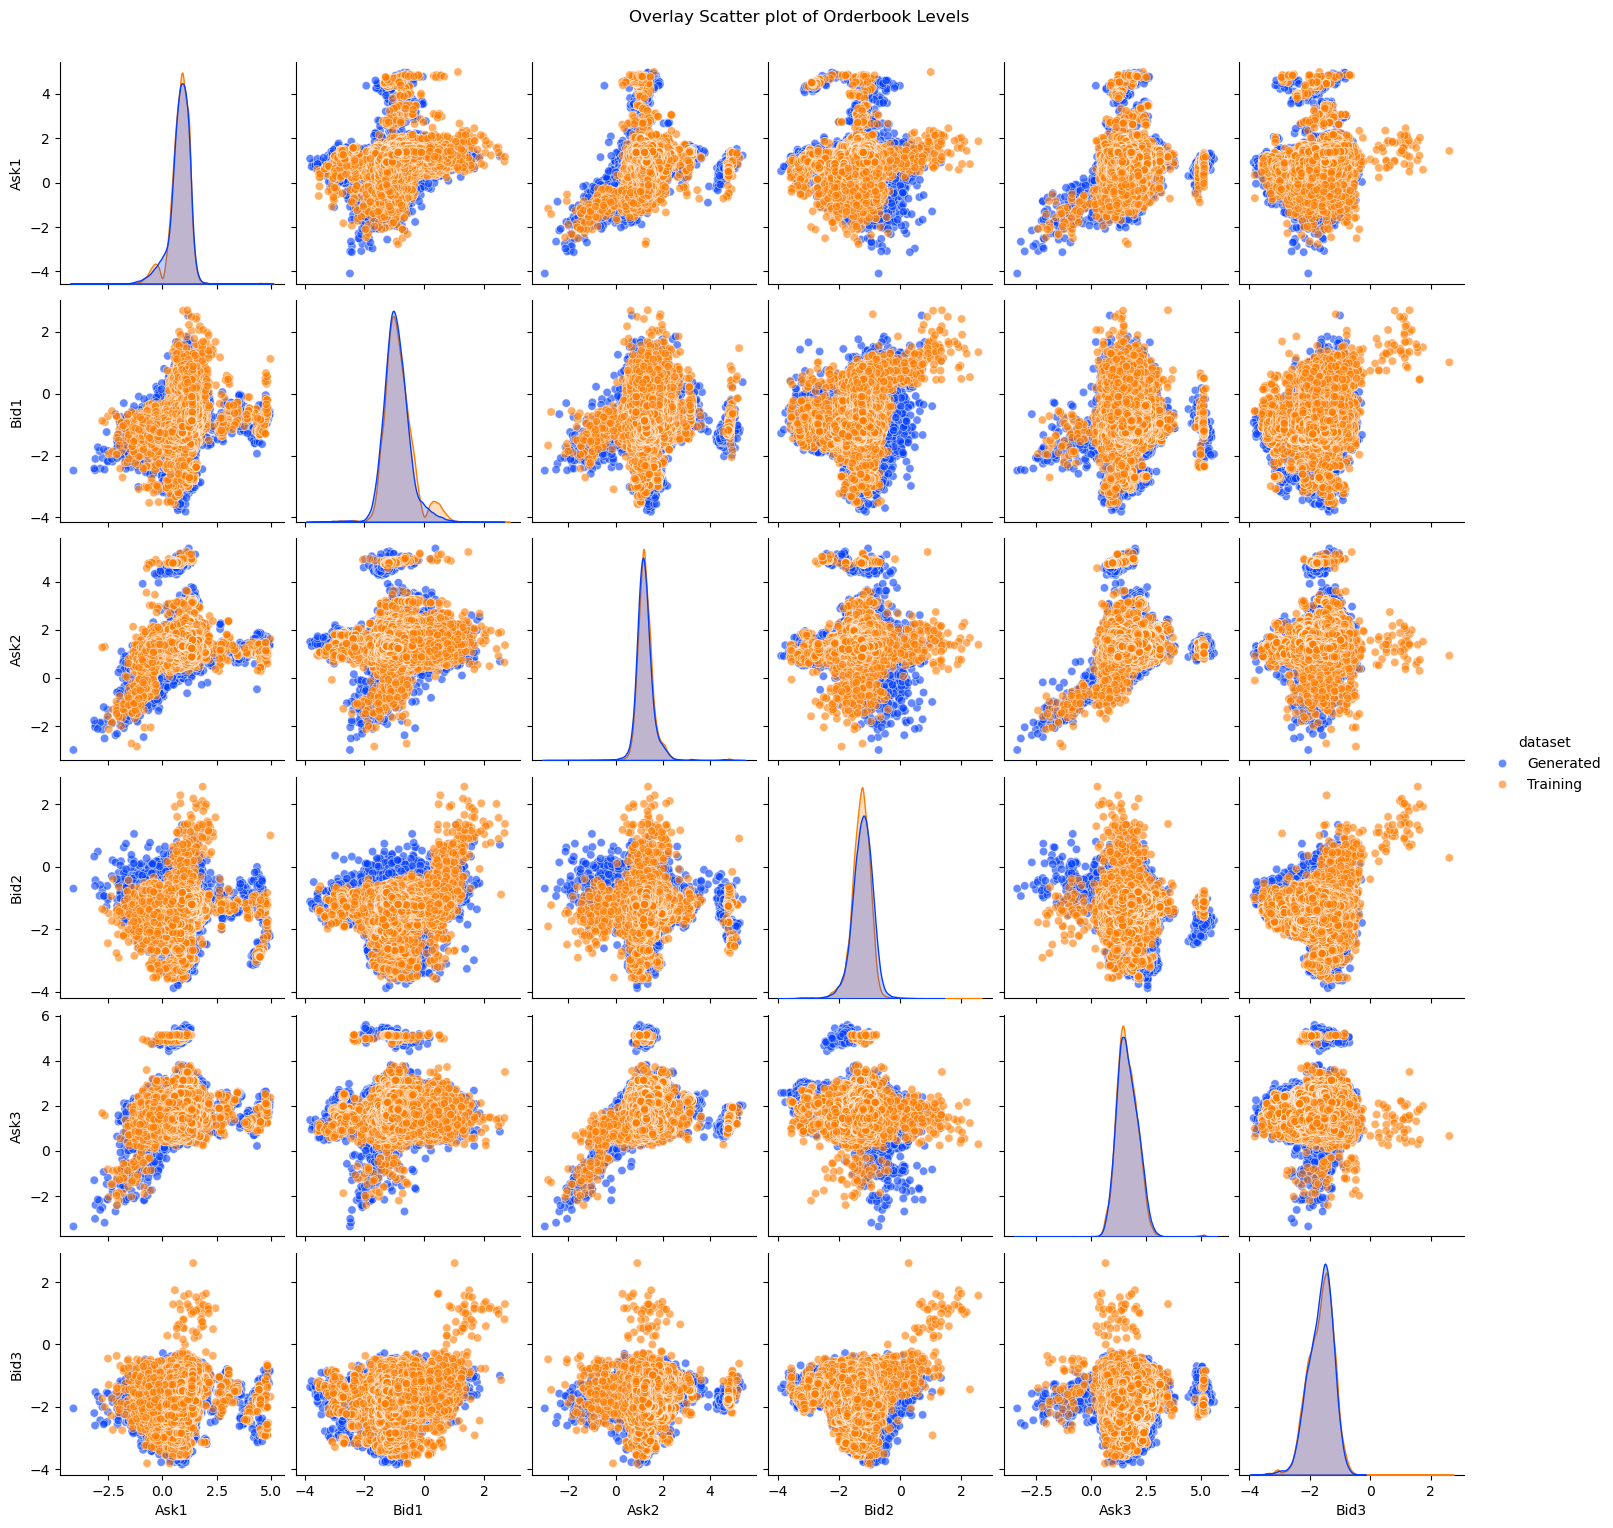

In [53]:
# Define variables to track progress
avg_d_loss = 0
avg_g_loss = 0
n_batches = len(data_loader)

for epoch in range(start_epoch, epochs):
    total_d_loss_epoch = 0
    total_g_loss_epoch = 0
    
    for i, (batch_X_t_delta_t, batch_S_t) in enumerate(data_loader):
        batch_size = batch_S_t.shape[0]
        
        batch_S_t = batch_S_t.to(device)
        batch_X_t_delta_t = batch_X_t_delta_t.to(device)

        # ---------------------
        #  Train Critic
        # ---------------------
        total_d_loss_batch = 0
        for _ in range(n_critic):
            optimizer_D.zero_grad()

            # Sample noise as generator input
            # batch_Z_t = torch.randn(batch_size, z_t_dim, device=device)  # Ensure noise_dim matches generator input
            batch_Z_t = generate_z_t(batch_size, z_t_dim, device)
            batch_X_t_delta_t_generated = generator(batch_Z_t, batch_S_t)

            real_validity = critic(batch_X_t_delta_t, batch_S_t)
            fake_validity = critic(batch_X_t_delta_t_generated, batch_S_t)
            gp = gradient_penalty(critic, batch_X_t_delta_t.data, batch_X_t_delta_t_generated.data, batch_S_t.data)
            
            # Wasserstein GAN loss w/ gradient penalty
            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + LAMBDA * gp

            d_loss.backward()
            # Gradient clipping
            torch.nn.utils.clip_grad_value_(critic.parameters(), 1.0)
            optimizer_D.step()
            total_d_loss_batch += d_loss.item()
            
        d_loss_batch = total_d_loss_batch / n_critic
        total_d_loss_epoch += d_loss_batch # Average over the n_critic updates
        
        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        # Resample noise (optional but often leads to better training stability)
        # batch_Z_t = torch.randn(batch_size, z_t_dim, device=device)
        batch_Z_t = generate_z_t(batch_size, z_t_dim, device)
        batch_X_t_delta_t_generated = generator(batch_Z_t, batch_S_t)
        fake_validity = critic(batch_X_t_delta_t_generated, batch_S_t)
        # Loss measures generator's ability to fool the discriminator
        g_loss = -torch.mean(fake_validity)

        g_loss.backward()
        optimizer_G.step()
        total_g_loss_epoch += g_loss.item()

    # Prints average loss per epoch
    avg_d_loss = total_d_loss_epoch / n_batches
    avg_g_loss = total_g_loss_epoch / n_batches
    avg_d_loss_list.append(avg_d_loss)
    avg_g_loss_list.append(avg_g_loss)
    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] completed. Avg D Loss: {avg_d_loss:.4f}, Avg G Loss: {avg_g_loss:.4f}")
        
    if (epoch + 1) % 500 == 0:
        write_metrics_to_wandb(epoch)
        
    if (epoch + 1) % 250 == 0:
        save_checkpoint(epoch, generator, critic, optimizer_G, optimizer_D, avg_d_loss, avg_g_loss, './saved_models/python/RecreatingBestModelBimodal.pth')
        
        
    write_loss_functions_to_wandb(avg_d_loss, avg_g_loss,epoch)
    # Resets average losses for the next epoch
    avg_d_loss = 0
    avg_g_loss = 0

# Close the writer after the training loop
writer.close()

6. Save Generator Model

In [ ]:
save_checkpoint(epoch, generator, critic, optimizer_G, optimizer_D, avg_d_loss, avg_g_loss, './saved_models/python/HorizontalExpansion.pth')

In [ ]:
# # Save the generator's state dictionary for python
# torch.save(generator.state_dict(), './saved_models/python/BatchSize64Base1000Epochs.pth')
# # Save the generator's state dictionary for c++
# z_t = torch.randn(1,z_t_dim)
# s_t = torch.tensor(S_t_dataset[0], dtype=torch.float32).unsqueeze(0)
# traced_script_generator = torch.jit.trace(generator, (z_t, s_t))
# traced_script_generator.save('./saved_models/cpp/BatchSize64Base1000Epochs.pt')

In [ ]:
with torch.no_grad():
    z_t = torch.randn(S_t_dataset.shape[0], z_t_dim)
    X_t_delta_t_generated = generator(z_t, S_t_dataset_tensor)

selu = nn.SELU()
data = X_t_delta_t_generated
data[:, 5] = data[:, 5]
data[:, 6] = data[:, 6]
condition_range = (-0.05, 0.05)
# # Check condition for the 5th column
condition_5th = (data[:, 5] >= condition_range[0]) & (data[:, 5] <= condition_range[1])
condition_6th = (data[:, 6] >= condition_range[0]) & (data[:, 6] <= condition_range[1])

# # Multiply values in the 5th column by 2 where condition is met
# data[:, 5] = torch.where(condition_5th, 5*torch.tanh(data[:, 5]), data[:, 5])
# data[:, 6] = torch.where(condition_6th, 5*torch.tanh(data[:, 6]), data[:, 6])

X_t_delta_t_generated = data
print(X_t_delta_t_generated.shape)
best_k_ask_bids = X_t_delta_t_generated[:, [6, 5, 7, 4, 8, 3]].cpu().numpy()
columns = ['Ask1', 'Bid1', 'Ask2', 'Bid2', 'Ask3', 'Bid3']
df = pd.DataFrame(best_k_ask_bids, columns=columns)
plt.figure()
sns.pairplot(df)
plt.title('Scatter plot of Orderbook Levels')
plt.show()

#### Generate 1 Example Orderbook Snapshot where the price has changed

In [ ]:
# Generate a sample order book snapshot
i=0
counter = 0
while (True):
    with torch.no_grad():
        if counter == 1: break
        i += 1
        z_t = torch.randn(1,z_t_dim)
        s_t = torch.tensor(S_t_dataset[0], dtype=torch.float32).unsqueeze(0)
        X_t_delta_t_example = generator(z_t, s_t)
        if reverse_normalization(X_t_delta_t_example)[0, 5] > 0 or reverse_normalization(X_t_delta_t_example)[0, 6] < 0:
            print(i)
            print("Current Order Book Snapshot:\t", reverse_normalization(s_t))
            print("Generated Order Book Snapshot:\t", reverse_normalization(X_t_delta_t_example))
            counter += 1
            
    
